## FAI1 - Practical Deep Learning I
Homework Jupyter Notebook for Lesson 1: Image Classification
See the full course at: http://course.fast.ai/

## Setup & Imports

Keras requires a directory structure based on the classes you are looking at. Our directory structure will be as follows:

In [50]:
# dogscats/
#     train/
#         dogs/
#         cats/
#     valid/
#         dogs/
#         cats/
#     test/
#         dogs/
#         cats/
#     sample/
#         <same as for dogscats/>

Setup matplotlib to plot inside the notebook, import NumPy, SciPy, VGG, and the appropriate Keras libraries.

In [15]:
# this ensures matplotlib plots within this window
%matplotlib inline
# path to my sample data directory. Contains 180 imgs in ../train/ and 20 
# imgs in ../valid/ The full dataset contains 25,000 imgs.
path = "data/dogscats/sample/"
# The libraries to be imported (taken from https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb)
from __future__ import division, print_function
import os, json
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots
import vgg16; reload(vgg16)
from vgg16 import Vgg16

## Vgg16 Image Recognition Example
We'll do a small test-run of Vgg16 to show what the data & labels look like. Afterwards we'll finetune & fit the model to our dataset (so that Vgg16 is looking for cats vs dogs instead of its standard 1,000 categories), run it on our full test set, and create a submissions csv file to upload to Kaggle and get scored.
First create a Vgg16 object:

In [16]:
vgg = Vgg16()

Get some batches from the sample training folder. vgg.get_batches(..) is an iterator that returns a batch of images and their labels, indefinitely.

In [20]:
batches = vgg.get_batches(path+'train',batch_size=4)

Found 180 images belonging to 2 classes.


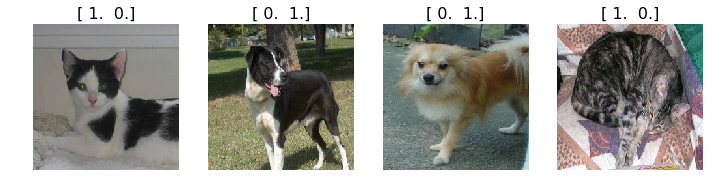

In [21]:
imgs, labels = next(batches)
plots(imgs, titles=labels)

To get an idea of the categories Vgg16 usually works with, here're the first 5:

In [22]:
vgg.classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

## Vgg16 finetuned for Dogs vs Cats:
What we do now is finetune and fit our model to our specific dataset. Finetuning further trains a pre-trained Machine-Learning model (Vgg16). A training set is trained on, and a validation set is tested against. In finetuning, we're only changing a small subset of our model's parameters since our pre-trained model is already very close to our final desired model. This is done by calling fit() after calling finetune()

In [24]:
batch_size = 32
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 180 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


Calling fineunte() modifies the model so that it'll be trained based on the data in the batches provided: dog vs cat. The model's parameters are then fitted using the training data, and accuracy is reported using teh validation set. An epoch is 1 full pass through the training data.

In [25]:
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
180/180 [==============================] - 65s - loss: 0.7958 - acc: 0.6889 - val_loss: 0.0573 - val_acc: 0.9500


The model is ready to classify dogs vs cats. In order to complete this assignment, we'll have to create a csv (comma-separated-values) file of IDs and labels of the full 25,000 set of images and upload it to Kaggle for scoring.

First modify the path to the full dataset:

In [29]:
path = "data/dogscats/"

vgg.test(..) will return the entire set of batches & predictions (labels). We'll extract the ID-number from batches.filenames, and the label from the second column of predictions.

In [33]:
batches, predictions = vgg.test(path+'test',batch_size=batch_size*2)
filenames = batches.filenames

Found 12500 images belonging to 1 classes.


The syntax for getting the IDs below is: make an array of the index of the period plus one, to fourth-from-end character, of each item f in filenames. The file extensions are all ".jpg" which is 4 characters long, and the ID number of each file comes after a period as such: "dog.0010.jpg" or "cat.1001.jpg" & etc.

# NOTE:
that didn't work for me here because the images aren't labelled. Instead they're just as "test//0010.jpg" and etc. So I just did a quick hack and indexed each file at [5:-4] which returns the proper slice (between 'test//' and '.jpg')

In [47]:
# print(filenames[:10])
# print(filenames[10][5:-4])

10006


In [49]:
# ids = np.array([int(f[f.find('.')+1:-4]) for f in filenames])
ids = np.array([int(f[5:-4]) for f in filenames])
dog_predictions = predictions[:,1]
submission = np.stack([ids, dog_predictions], axis=1)
submission_file_name = 'submission_HW1_.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f',header='id,label',comments='')

And that's it kurzgesagt. Find the original Jupyter Notebook here: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb

And a great walkthrough here: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/dogs_cats_redux.ipynb

WH Nixalo - 1 Seli 2017 12:47

# NOTE2:
I don't know if I had to specify not to shuffle the data from vgg.test(..). If so, my 12,500-long csv file would be useless, or at the very least would need to be sorted. Will see about this more in the 2nd lecture, and may return to fix that here.

'Till then, here was the first time I used a model to generate predictions on a 'real' dataset and save an output file. Will post Kaggle score when I upload. For a Intel Core i7-4710HQ CPU it only took about an hour or two. A lot better than I expectd. Though, it will be *much* faster once I setup GPU support for the GTX 870M.

Update from lesson 2: clipping the probabilities to 0.05 and 0.95 to mitigate LogLoss overconfidence penalty from Kaggle.

Also using above, got me to 734/1314 rank in Kaggle w/ error score of 0.16309

In [51]:
updated_preds = np.clip(dog_predictions, 0.05, 0.95)

As you can see below, I had quite a few zeros and ones... That deffinitely affected my score.

In [52]:
print (updated_preds[:10])

[ 0.8514  0.05    0.2467  0.95    0.95    0.05    0.05    0.95    0.95    0.6997]


So now, I'll write a new submission file, upload that, and see what this tiny tweak does.

In [54]:
submission = np.stack([ids,updated_preds], axis=1)
np.savetxt(submission_file_name, submission, fmt='%d,%.5f',header='id,label',comments='')